In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
from sklearn import datasets,linear_model
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [3]:
#definujeme ktore atributy v stlpcoch chceme brat na predikciu
def nacitaj(stlpce, nY, data):
    X = []
    Y = data[:,nY]
    for s in stlpce:
        X = np.append(X,data[:,s])
    return X.reshape(len(stlpce), len(data)), Y

In [4]:
stlpce = np.append(np.arange(1,5),(np.arange(7,38)))
data = np.loadtxt('final.txt', comments='#', delimiter=',') #nacitanie dat
X, Y = nacitaj(stlpce,5,data)
print(X.shape)

(35, 42277)


In [5]:
import pandas as pd

names = ['id', 'vyska', 'sirka', 'plocha', 'vyfarbena_cast', 'cas', 'pocet_riesitelov', 'pocet_0_riadkov', 'pocet_iter_DYN', 'apl_DYN', 'pocet_iter_LR', 'pravidlo01','pravidlo02','pravidlo03','pravidlo04','pravidlo05','pravidlo06','pravidlo07','pravidlo08','pravidlo09','pravidlo10','pravidlo11','pravidlo12','pravidlo13','doriesene_LR', 'set01','set02','set03','set04','set05','set06','set07','set08','set09','set10','set11','set12','set13']
dataset = pd.read_csv('final.txt', sep=',', names=names)
print(dataset.describe())

                  id         vyska         sirka        plocha  \
count   42277.000000  42277.000000  42277.000000  42277.000000   
mean    84306.615110     33.864631     33.558412   1335.540507   
std     47272.726889     14.999751     15.159092    888.209498   
min       303.000000      3.000000      3.000000     24.000000   
25%     41688.000000     25.000000     23.000000    540.000000   
50%     84070.000000     35.000000     35.000000   1250.000000   
75%    126792.000000     50.000000     50.000000   2250.000000   
max    163456.000000    100.000000    100.000000   8550.000000   

       vyfarbena_cast           cas  pocet_riesitelov  pocet_0_riadkov  \
count    42277.000000  42277.000000      42277.000000     42277.000000   
mean       554.459020   1103.874447        687.867966         3.968919   
std        455.223953   1231.052232       1003.102433        10.246959   
min          1.000000      2.000000          3.000000         0.000000   
25%        185.000000    269.000000

Nacitame si data a teraz rozdelime na atributy, ktorymi chceme odhadovat nasu hodnutu - v stlpci 5- priemerny cas vyriesenia krizovky. Nulty stlpec a 6. vyhodime


In [6]:
#priklad nacitania len konkretnych stlpcov 0-10
ddd = nacitaj(np.arange(10),5, data)


teraz si vizualizujeme data

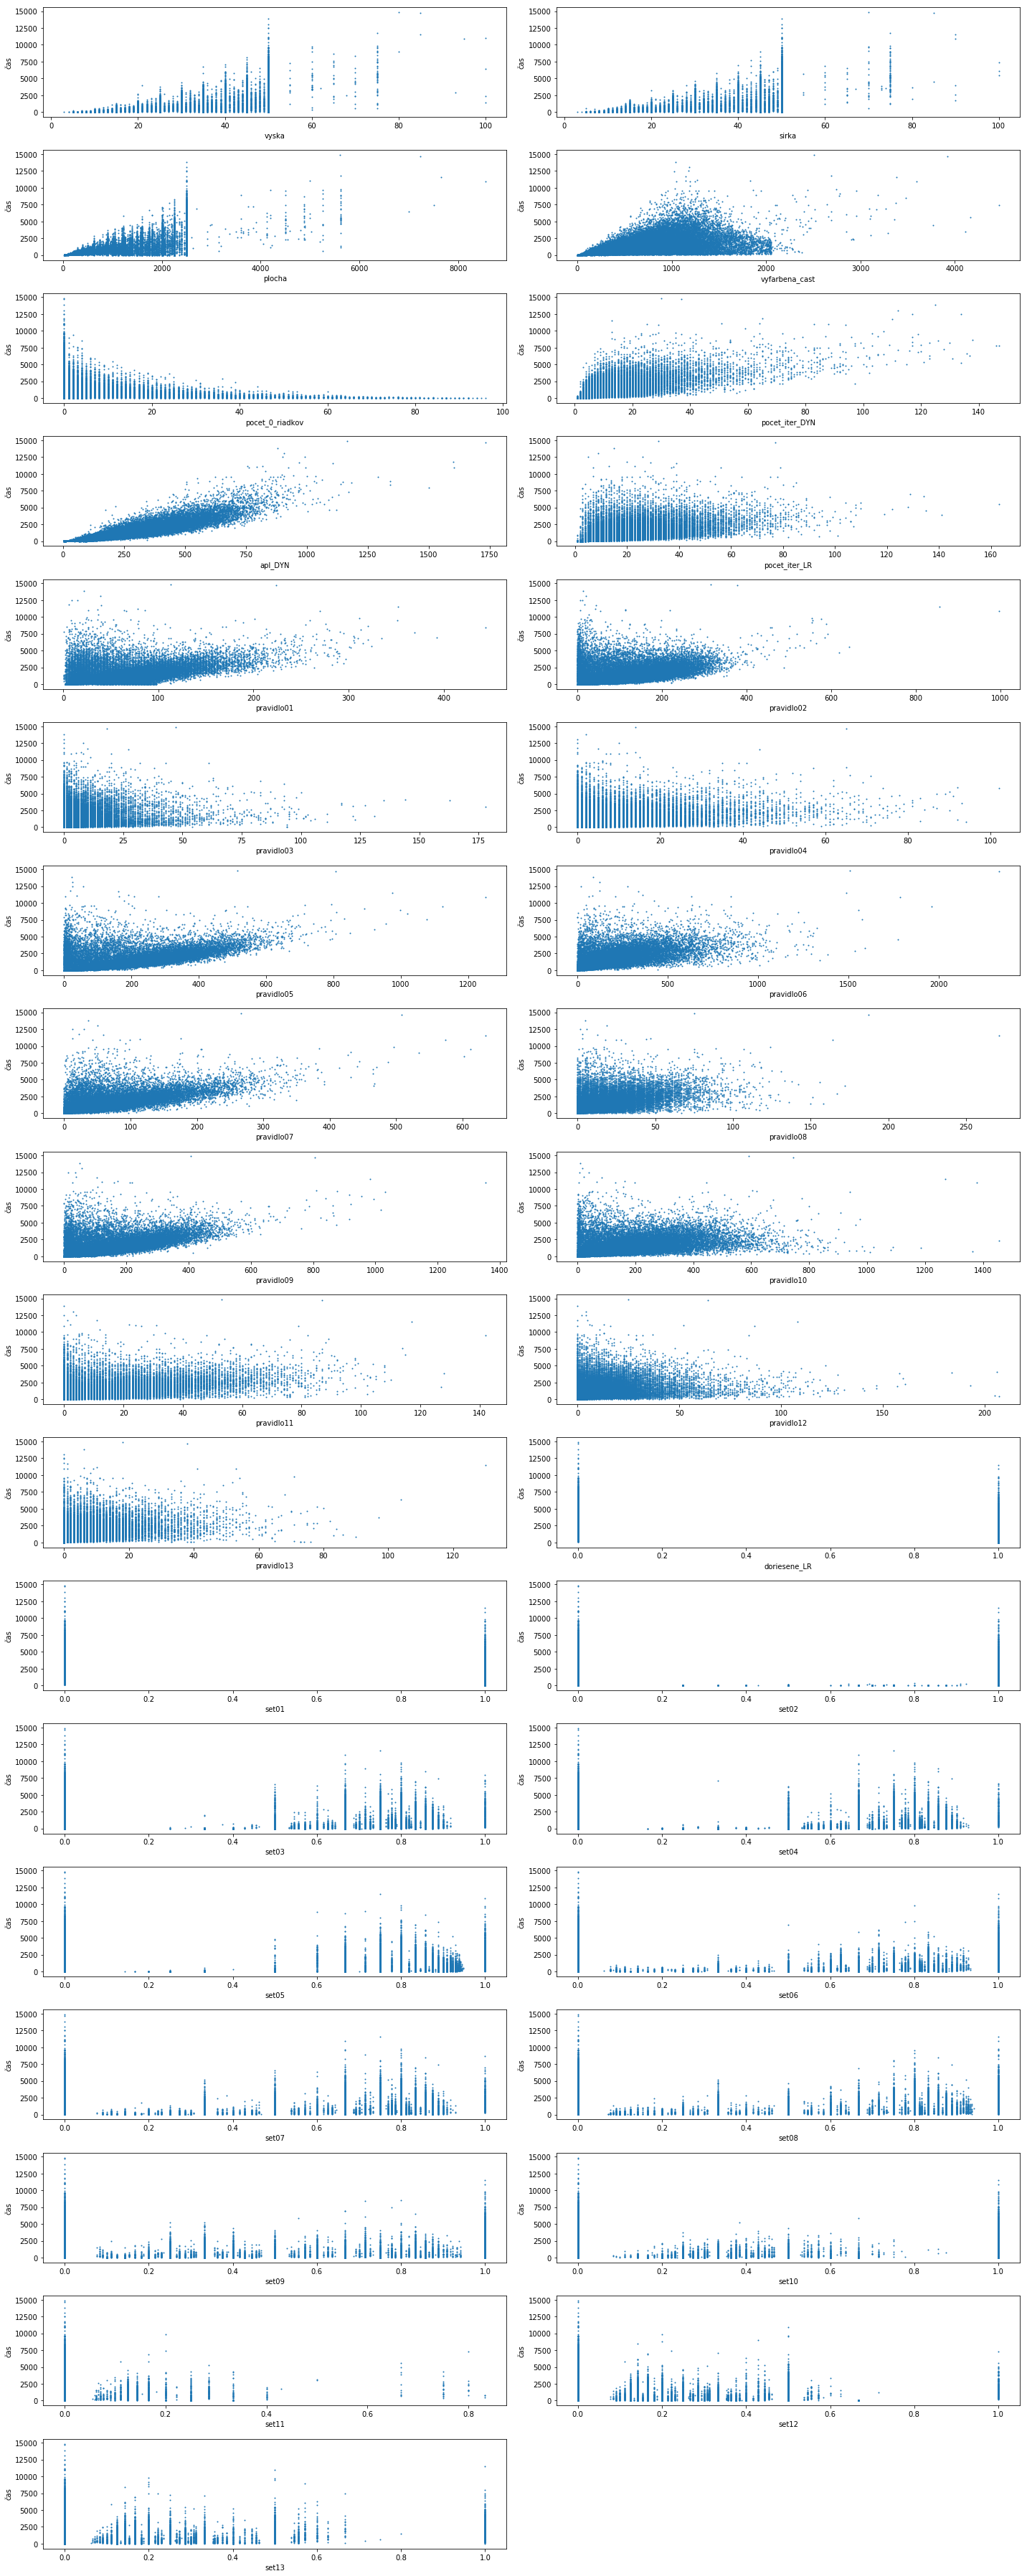

In [7]:
leg = ['vyska', 'sirka', 'plocha', 'vyfarbena_cast', 'pocet_0_riadkov', 'pocet_iter_DYN', 'apl_DYN', 'pocet_iter_LR', 'pravidlo01','pravidlo02','pravidlo03','pravidlo04','pravidlo05','pravidlo06','pravidlo07','pravidlo08','pravidlo09','pravidlo10','pravidlo11','pravidlo12','pravidlo13','doriesene_LR', 'set01','set02','set03','set04','set05','set06','set07','set08','set09','set10','set11','set12','set13']


plt.figure(figsize=(20, 50))
for cnt in range(len(X)):
    plt.subplot(18, 2, cnt+1)
    plt.scatter(x=X[cnt], # x-axis: feat. from col. 1
                y=Y,
                s=1,
               )
    plt.xlabel(leg[cnt])
    plt.ylabel("čas")
    
plt.tight_layout()
plt.show()

In [8]:
def zobraz_disp(mask, Y, label):
    plt.hist(Y[mask], bins=100,alpha=0.3,)
    plt.xlabel(label)
    return plt.show()

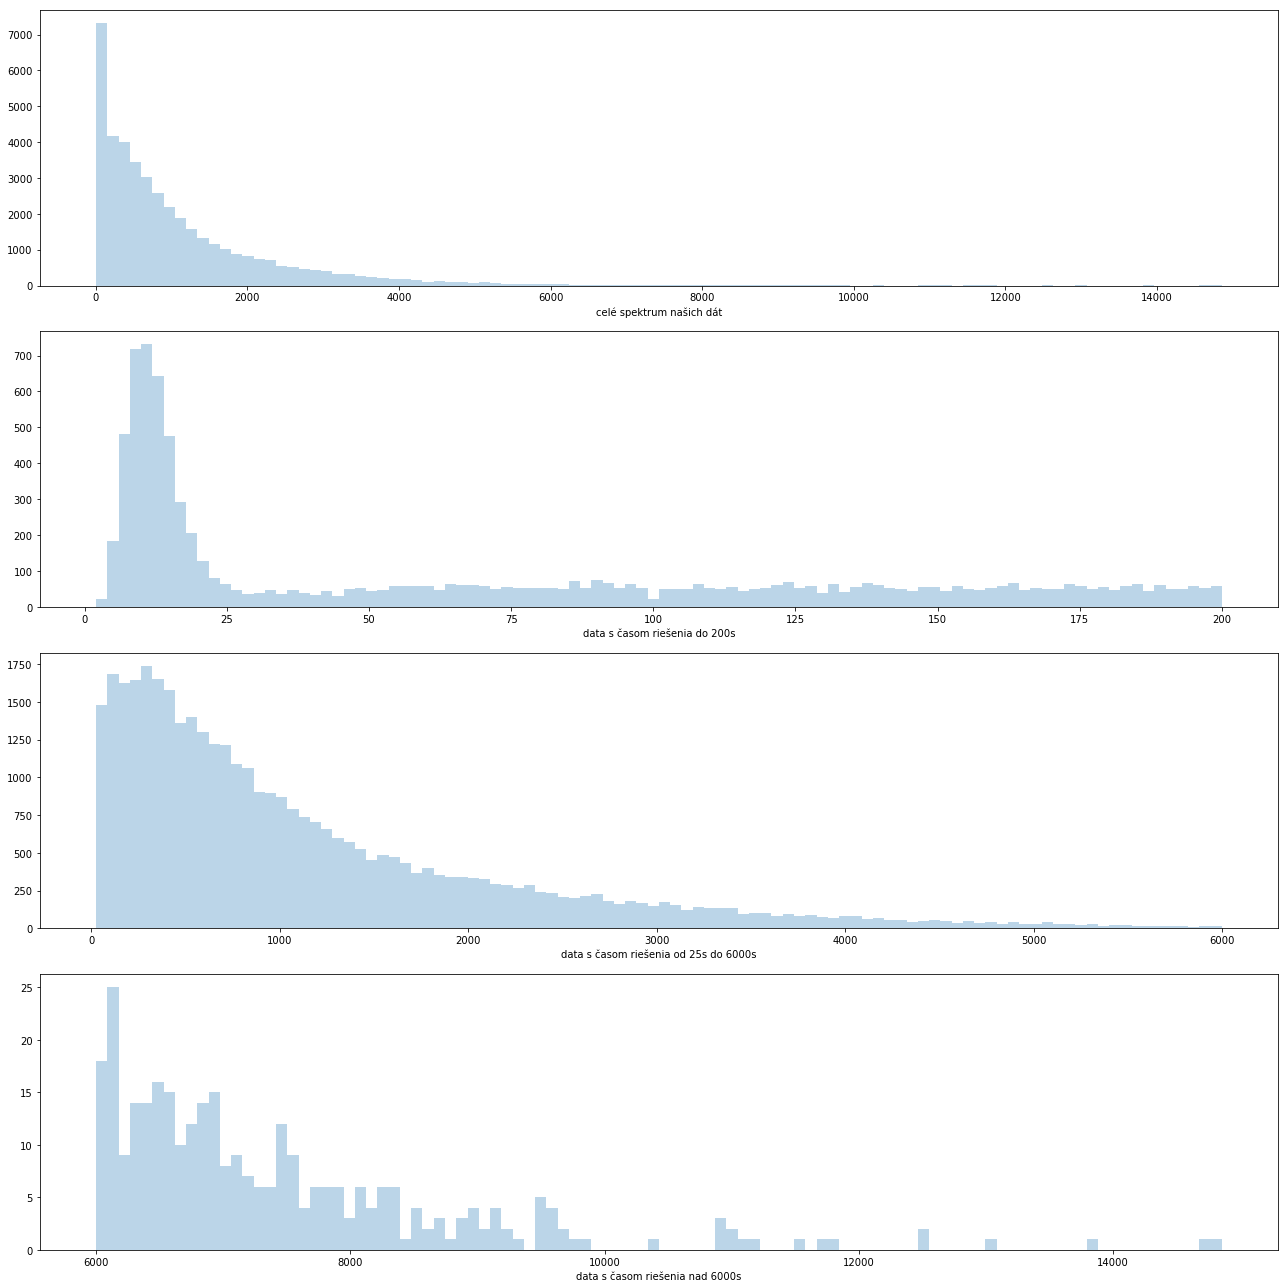

In [9]:

plt.figure(figsize=(18, 18))

#zobraz_disp(True, Y,"celé spektrum našich dát" )

plt.subplot(4, 1, 1)
plt.hist(Y,bins=100,alpha=0.3,)
plt.xlabel("celé spektrum našich dát")


plt.subplot(4, 1, 2)
plt.hist(Y[Y<=200], bins=100,alpha=0.3,)
plt.xlabel("data s časom riešenia do 200s")


mask = ((Y>25) & (Y<6000))
plt.subplot(4, 1, 3)
plt.hist(Y[mask],bins=100,alpha=0.3,)
plt.xlabel("data s časom riešenia od 25s do 6000s")

plt.subplot(4, 1, 4)
plt.hist(Y[Y>=6000],bins=100, alpha=0.3,)
plt.xlabel("data s časom riešenia nad 6000s")

plt.tight_layout()
plt.show()




In [10]:
#definujeme ktore atributy v stlpcoch chceme brat na predikciu
def nacitaj(stlpce, nY, data):
    X = []
    Y = data[:,nY]
    for s in stlpce:
        X = np.append(X,data[:,s])
    return X.reshape(len(stlpce), len(data)).T, Y

oddelime testovacie data od tych na trenovanie

In [11]:
def rozdel(X, Y, pocet_test):
    pocet_tren = len(X) - pocet_test 

    X_tren = X[0:pocet_tren]
    X_test = X[pocet_tren:pocet_tren+pocet_test]
    Y_tren = Y[0:pocet_tren]
    Y_test = Y[pocet_tren:pocet_tren+pocet_test]
    
    return X_tren, X_test, Y_tren, Y_test


upravime zvlast trenovacie aj testovacie data, aby bol priemer 0 a odchylka 1 

In [12]:
#normalizacia dat
def znormalizuj(tren, test):
    X_std = StandardScaler().fit_transform(tren)
    X_stdTest = StandardScaler().fit_transform(test)
    return X_std, X_stdTest
    #return tren, test

Ako model sme si zvolili linearnu regresiu

In [13]:
def trenuj(X, Y):
    LIN = linear_model.LinearRegression(normalize=True)
    LIN.fit(X, Y)
    return LIN

def priemOdchylka(Y,p):
    return np.mean(np.abs(Y-p))

def predikuj(f, X, Y):
    p = f.predict(X)
    od = priemOdchylka(Y,p)
    s = f.score(X,Y)
    return p, s, od


In [14]:
def graf_predpovedi(Y,p, title):    
    plt.figure(figsize=(13, 13))
    plt.scatter(Y, p,s=3)
    plt.xlabel("Skutocne hodnoty")
    plt.ylabel("Predikcie")
    plt.title(title)
    return plt.show()

In [15]:
def graf_odchylok(Y,p, title):
    plt.figure(figsize=(15, 5))
    plt.scatter(Y, p-Y,s=3)
    plt.xlabel("Skutocne hodnoty")
    plt.ylabel("Predikcie")
    plt.title(title)
    return plt.show()

V pripade lin. regresie, fukcia score vyjadruje coeficient determinacie R^2, ktory vyjadruje kvalitu nasej predpovede - najlepsi mozny vysledok je 1

In [16]:
def skus_model(data,stlpce,nY,pocet_test,grafy):
    X,Y = nacitaj(stlpce,nY,data)
    X_tren,X_test,Y_tren,Y_test = rozdel(X,Y,pocet_test)
    mean= np.mean(X_tren)
    std= np
    
    F = trenuj(X_tren,Y_tren)
    p_tren, tren_score, od_tren = predikuj(F,X_tren, Y_tren)    
    print("tren_score: ",tren_score)
    print("tren odchylka:", od_tren)
    
    cross = cross_val_score(F, X_tren, Y_tren, cv=10)
    print("cross validacne score:", np.mean(cross))
    
    p_test, test_score, od_test = predikuj(F,X_test, Y_test)    
    print("test_score: ",test_score)
    print("test odchylka:", od_test)
    
    if(grafy):
        graf_predpovedi(Y_tren, p_tren, "trenovacie predpovede")
        graf_odchylok(Y_tren, p_tren, "trenovacie odchylky")
        graf_predpovedi(Y_test, p_test, "testovacie predpovede")
        graf_odchylok(Y_test, p_test, "testovacie odchylky")
    
    return F

tren_score:  0.89253474386
tren odchylka: 235.526437538
cross validacne score: 0.887217678621
test_score:  0.891025219936
test odchylka: 173.390447525


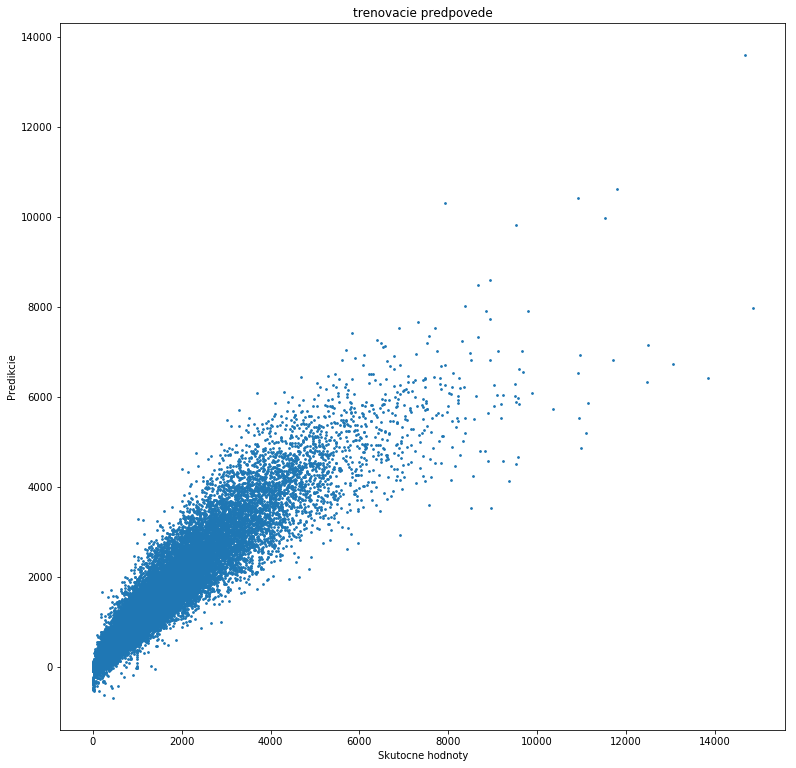

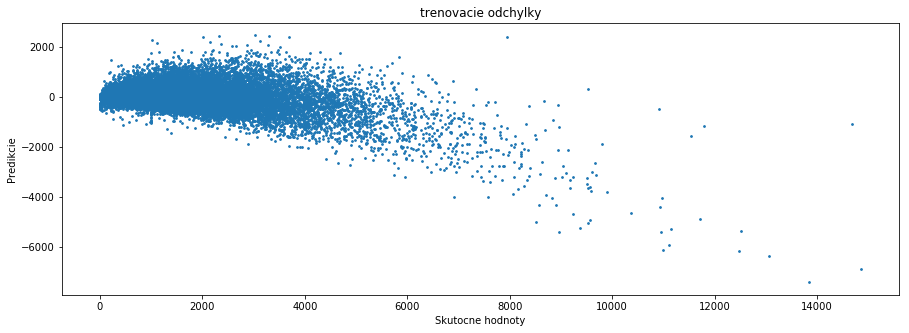

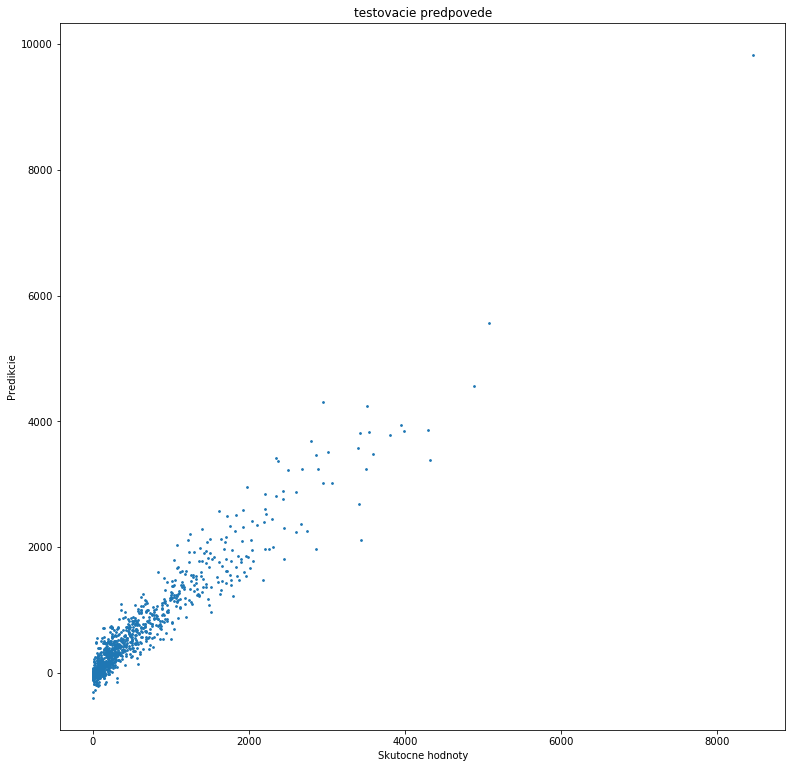

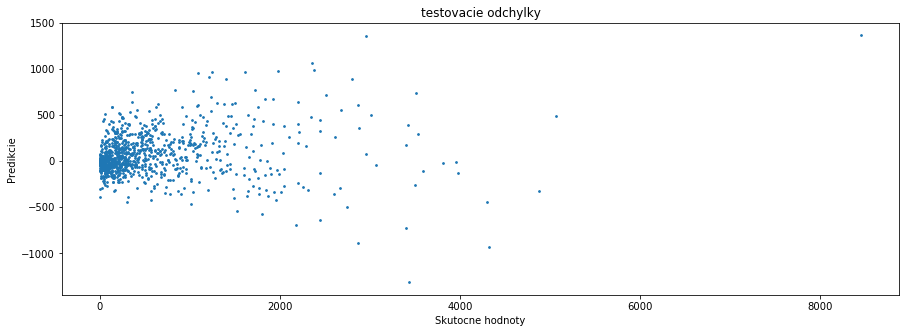

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [29]:
#pouzivame vsetky atributy aj stlpce
stlpce = np.append(np.arange(1,5),(np.arange(7,38)))
skus_model(data, stlpce, 5, 1000, True)


In [18]:
#pouzivame vsetky atributy aj stlpce ale zvacsime testovaciu mnozinu
stlpce = np.append(np.arange(1,5),(np.arange(7,38)))
skus_model(data, stlpce, 5, 10000, False)


tren_score:  0.891263612852
tren odchylka: 243.27789515
cross validacne score: 0.885177910585
test_score:  0.892979336517
test odchylka: 209.048015086


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

tren_score:  0.899729013963
tren odchylka: 262.745831648
cross validacne score: 0.891119506158
test_score:  0.863125437797
test odchylka: 259.044781412


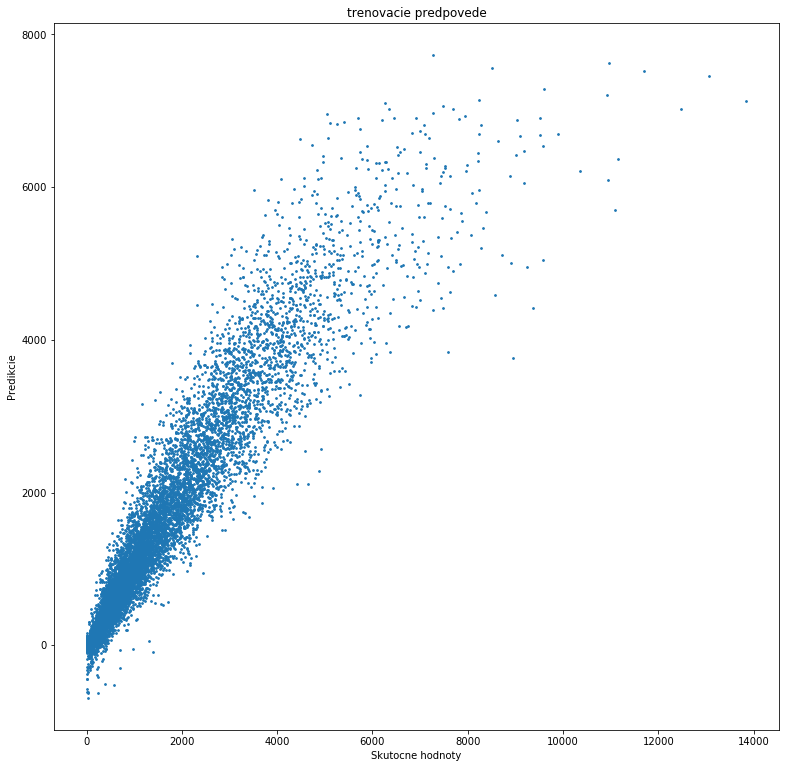

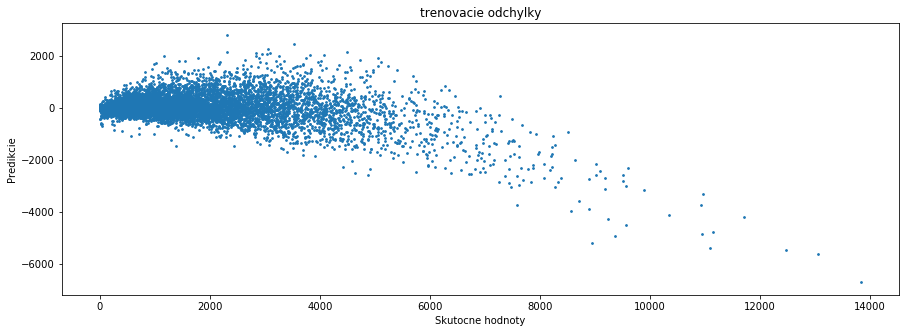

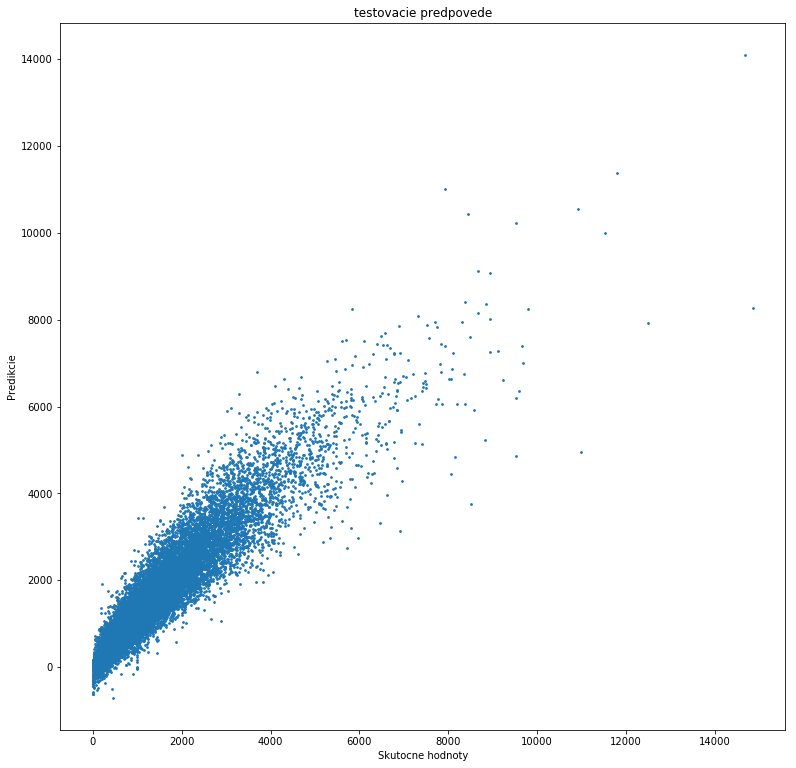

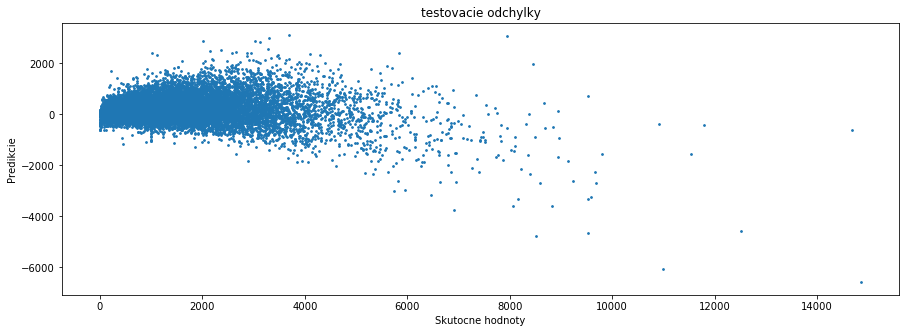

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [35]:
#pouzivame vsetky atributy aj stlpce ale este viac zvacsime testovaciu mnozinu
stlpce = np.append(np.arange(1,5),(np.arange(7,38)))
skus_model(data, stlpce, 5, 30000, True)


tren_score:  0.854586695328
tren odchylka: 193.687774938
cross validacne score: 0.84864185321
test_score:  0.828030628122
test odchylka: 180.102581869


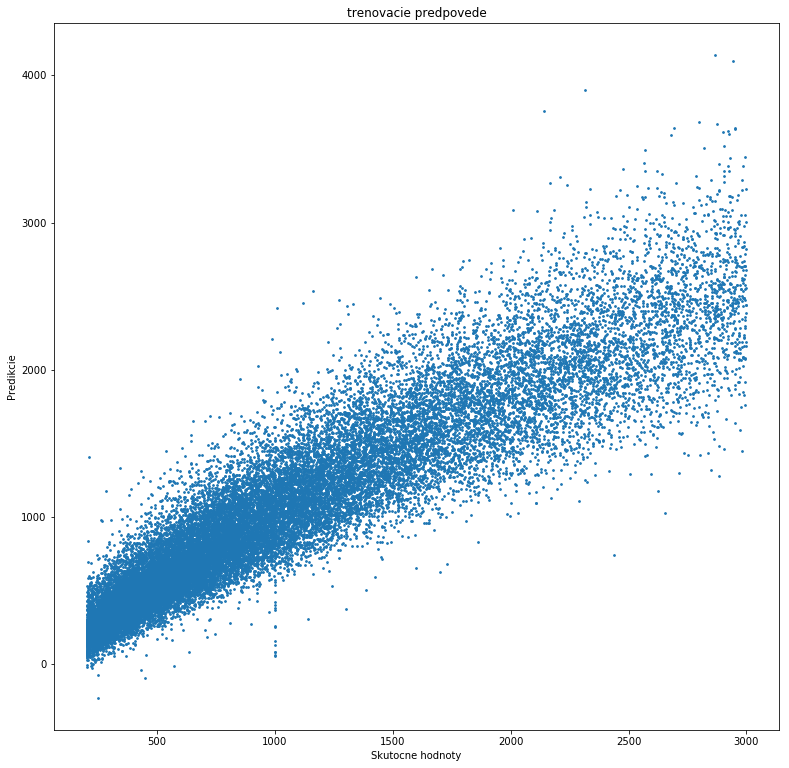

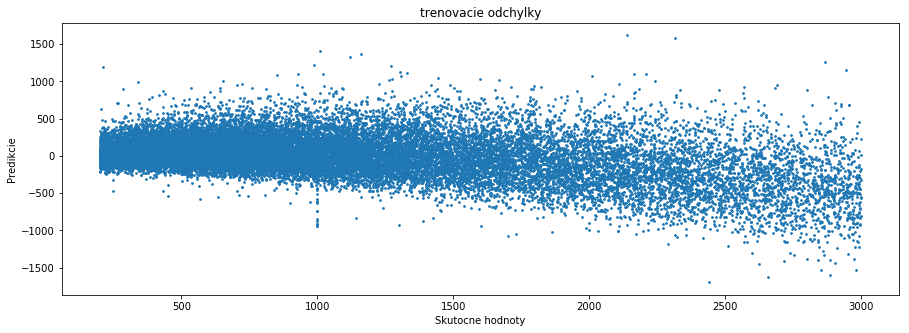

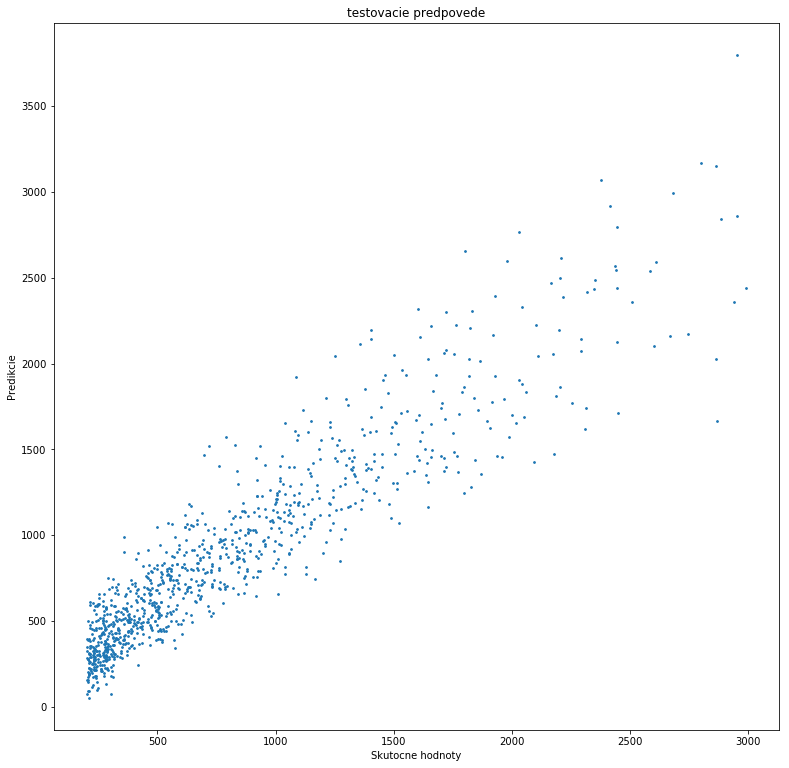

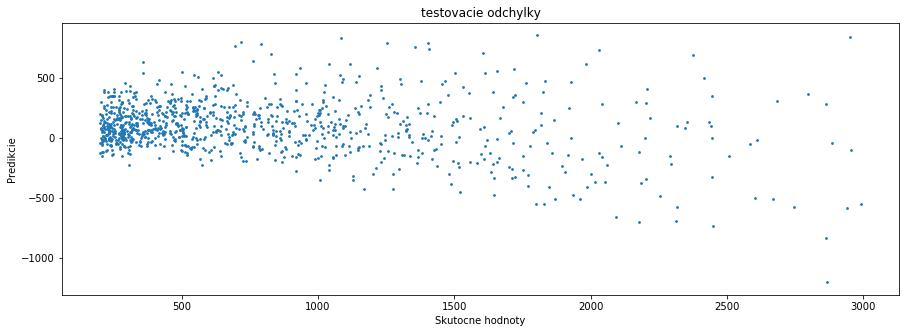

(30263, 38)


In [36]:
#pouzijeme len data, kde je cas v rozmedzi 200-3000 sek
stlpce = np.append(np.arange(1,5),(np.arange(7,38)))
m = ((Y>200) & (Y<3000))
skus_model(data[m], stlpce, 5, 1000, True)
print(data[m].shape)

In [33]:
#pouzijeme len data, kde je cas v rozmedzi 25-6000 sek
stlpce = np.append(np.arange(1,5),(np.arange(7,38)))
m = ((Y>25) & (Y<6000))
F= skus_model(data[m], stlpce, 5, 1000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.893826775035
tren odchylka: 232.396311785
cross validacne score: 0.886849530951
test_score:  0.881746025909
test odchylka: 175.449030172
[ -10.  -10.    0.   -0.  -10.   -0.   10.    0.   10.   -0.    0.   10.
   -0.    0.    0.   10.   -0.   -0.   -0.    0.    0. -250.   90.   50.
   -0. -120.  -10.   30.  -40.   30.  -30.   30. -160.   40.  100.]


In [34]:
#pouzijeme len data, kde je cas v rozmedzi 100-4000 sek
stlpce = np.append(np.arange(1,5),(np.arange(7,38)))
m = ((Y>100) & (Y<4000))
F= skus_model(data[m], stlpce, 5, 1000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.881164036293
tren odchylka: 211.178558928
cross validacne score: 0.874806089697
test_score:  0.874372605736
test odchylka: 179.821006161
[ -10.  -10.    0.   -0.  -10.   -0.   10.    0.   10.   -0.    0.   10.
   -0.   -0.    0.    0.   -0.   -0.   -0.    0.    0. -630.  690. -320.
  -30. -190.   20.   80.  -20.   30.  -20.   40.  -90.   40.  100.]


In [23]:
stlpce = [24,25,26,28,29,31,32,35,36,37]
F= skus_model(data, stlpce, 5, 10000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.368635838276
tren odchylka: 692.392706319
cross validacne score: 0.327882148397
test_score:  0.236899762425
test odchylka: 625.938127083
[-1700. -1440.   420. -1080.   850.  -410.  2010.   550.  -490.   460.]


In [24]:
stlpce = [3]
F= skus_model(data, stlpce, 5, 10000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.427553207016
tren odchylka: 594.068068957
cross validacne score: 0.41018883297
test_score:  0.101574436353
test odchylka: 745.672732861
[ 0.]


In [25]:
stlpce = [3,4,9,10]
F= skus_model(data, stlpce, 5, 10000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.835638445571
tren odchylka: 318.64467188
cross validacne score: 0.827554147593
test_score:  0.816101161808
test odchylka: 301.69567815
[ -0.   0.  10. -10.]


In [26]:
stlpce = [9]
F= skus_model(data[m], stlpce, 5, 10000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.801866814638
tren odchylka: 347.031883336
cross validacne score: 0.792834972571
test_score:  0.785296575394
test odchylka: 305.605384586
[ 10.]


In [27]:
stlpce = [8,9,10,12,16,20,19,23]
F= skus_model(data, stlpce, 5, 10000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.855109842911
tren odchylka: 293.531762369
cross validacne score: 0.848032399868
test_score:  0.846876792583
test odchylka: 270.001155162
[  0.  10.   0. -10.   0.  -0.   0.  10.]


In [28]:
stlpce = np.append(np.arange(3,5),(np.arange(7,38)))
F= skus_model(data, stlpce, 5, 1000, False)
print(np.around(F.coef_, decimals=-1))

tren_score:  0.889315837057
tren odchylka: 246.606355627
cross validacne score: 0.883188707919
test_score:  0.879339940951
test odchylka: 190.890961339
[  -0.   -0.  -10.   10.   10.   -0.   10.   -0.    0.   10.   -0.    0.
   10.   10.   -0.   -0.  -10.    0.    0.  150.  300. -130.   50. -140.
 -100. -100.  -40.   20.  -40.   50. -260.   60.  100.]
